# AI18기 박경훈 Section3_Project
* 고기가 신선한지 상한건지 판단해주는 간단한 모델 개발
* 휴대폰앱으로 적용하는것을 가정. IDC와 정보교환은 x  
=>휴대폰 환경에서 계산.
* 모델이 간단하므로 유명한 Net 불러오지 않고 원리만 이해해서  
더 작고빠른 커스텀 모델 만들어보기

## 데이터불러오기 및 전처리
* Tabular데이터가 아닌 이미지데이터이므로 일반적인 EDA X
* 이미지 폴더를 눈으로 확인결과 별다른 중복및 이상사진은 X  
로테이션은 기본적으로 되어있음.  
=> 휴대폰 사진환경을 고려하여 밝기, 대비를 증강하여 fit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

import os
import PIL
import gc

# 가끔 냉장고에 있던 고기나 팔고있는 고기가 상한건지 아닌지 궁금할떄가 있다.
# 사소한 일이기때문에 전문가에게 물어보기도 뭐하고, 전문가가 아니면 알기도 힘들다.
# 이를 휴대폰에 설치되는 간단한 앱을 통해 구분할 수 있게하고자 한다.
# 서버와 통신없이 에지에서 추론시키기 위해서 모델은 가벼워야 한다.
# 이미지 데이터이므로 기존 머신러닝활용은 힘듦 => CNN기반의 딥러닝 활용

# data불러오기. 0:신선함, 1:반쯤신선함(주의), 2:상함
# file_name에 경로와 파일이름을 전부 기록하고, spoiled에 타겟값 저장
data_dir = 'Section3_project/dataset/'
root_dir = 'C:\\Users\\dynam\\desktop\\AIB'
os.chdir(root_dir)

def load_data(file_dir):
    fresh = os.listdir(data_dir+file_dir+'/meat_fresh')
    fresh = list(map(lambda x: data_dir+file_dir+'/meat_fresh/'+x, fresh))
    spoiled = os.listdir(data_dir+file_dir+'/meat_spoiled')
    spoiled = list(map(lambda x: data_dir+file_dir+'/meat_spoiled/'+x, spoiled))
    a = pd.DataFrame(fresh , columns=['file_name'])
    a['spoiled'] = 0
    b = pd.DataFrame(spoiled , columns=['file_name'])
    # HALF-FRESH인것들 전부 FRESH로 판정
    b['spoiled'] = b.file_name.str.contains(r'HALF').map(
        lambda x: 1 if x==True else 2)
    ds = pd.concat([a,b], axis=0).reset_index(drop=True)
    return ds

train = load_data('train')
valid = load_data('valid')
test = load_data('test')

훈련세트 개수 :  4726
검증세트 개수 :  460
훈련+검증세트 개수: 5186
테스트세트 개수 :  226


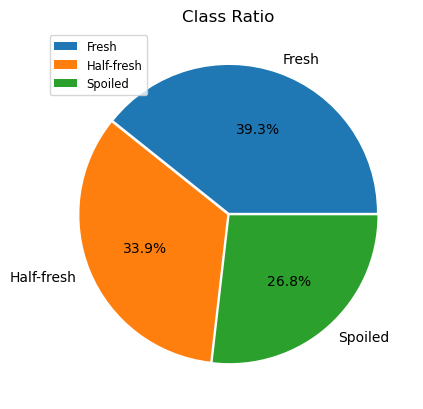

In [2]:
# 별다른 결측치 없음. 중복치없음.

# 훈련+검증 및 테스트 세트 개수확인
print('훈련세트 개수 : ',train.shape[0])
print('검증세트 개수 : ',valid.shape[0])
print('훈련+검증세트 개수:',end=' ')
print(train.shape[0]+valid.shape[0])
print('테스트세트 개수 : ',test.shape[0])
# 훈련세트의 약 10%가 검증세트이며, 5%가 테스트세트

# class 비율 확인
plt.pie(train.spoiled.value_counts(normalize=True),
       autopct='%.1f%%',
       labels=['Fresh','Half-fresh','Spoiled'],
       explode=[0.01, 0.01, 0.01])
plt.legend(loc=2, fontsize='small')
plt.title('Class Ratio')
plt.show()
# class는 균형잡혀있다.

* 클래스는 균형잡혀있으므로 Accuracy가 적합한 metric
* 클래스가 3개이므로 Chance Level ~ 0.33

In [3]:
from tqdm import tqdm

# 이미지 어레이로 변경 후 반환
def datapipe(data):
    os.chdir(root_dir)
    data = data.sample(frac=1, random_state=42)
    temp = []
    for img_name in tqdm(data.file_name):
        img = keras.utils.load_img(img_name, target_size=[224,224])
        ary = np.array(img).astype('float32')/255
        temp.append(ary)
    X = np.array(temp) # (len(data), 224, 224, 3)
    y = np.array(data.spoiled)
    return X, y

X_train, y_train = datapipe(train)
X_val, y_val = datapipe(valid)
X_test, y_test = datapipe(test)

100%|███████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 329.91it/s]


In [133]:
# tf.Dataset 오브젝트 변환 후 저장(코랩에서 모델연산)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

path = 'Section3_project/to_colab_data/'


# tf.data.Dataset.save(train_ds, path+'train',
#                     compression='None')
# tf.data.Dataset.save(valid_ds, path+'valid',
#                     compression='None')
# tf.data.Dataset.save(test_ds, path+'test',
#                     compression='None')


## 모델구성 및 평가
### 모델 구성
* 모델은 2개 구성.  규모가 작은 모델이므로 커스텀해서 사용
* 첫번째 모델: pre-activation, bottle neck적용한 Custom ResNet
* 두번째 모델: pre-activation, SEBlock, MBConVBlock 적용한 ResNet
* 모델구성이후 피팅은 코랩에서 진행 (section3_project_colab.ipynb 참조)
---
* 기존 CNN 아키텍쳐 파라미터 개수 참고 ▼  
* ResNetV2 backbone : 23,564,800개
* MobileNetV2 backbone : 2,223,872개
* EfficientNetV2B0 backbone : 5,919,312개

### 모델평가
* 평가는 각 모델별로 validation accuracy 및 latency확인 후 더 좋은것으로 결정.
* 결정된 모델을 test set으로 최종평가
* 이미지데이터이므로 SHAP, PDP, ICE같은걸 사용하기 힘들다.  
=> xAI 관련내용은 비포함..

### BaseModel
* 딥러닝 방식 적용이 옳은지를 판단하기 위해 기존 ML모델 사용해보기
* 기존모델은 별다른 튜닝없이도 괜찮은 성능을 보여주는 RandomForest 채택
* CNN처럼 이미지 행렬 그대로 input으로 받진 못하므로, (Batch, 224*224)형태로 투입

In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
# from sklearn.metrics

ohe = OneHotEncoder()
rf_model = RandomForestClassifier(verbose=1,
                                 n_jobs=-1)
# color값은 mean으로 사용
X_train_ml = X_train.mean(axis=-1).reshape([4726,224*224])
X_val_ml = X_val.mean(axis=-1).reshape([X_val.shape[0],224*224])
y_train_ml = ohe.fit_transform(y_train.reshape(-1,1)).toarray()
y_val_ml = ohe.transform(y_val.reshape(-1,1)).toarray()

rf_model.fit(X_train_ml, y_train_ml)
base_acc = rf_model.score(X_val_ml, y_val_ml)

del X_train_ml
del X_val_ml
del y_train_ml
del y_val_ml
gc.collect()

print(f"RF accuracy : {base_acc}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


RF accuracy : 0.3173913043478261


* 검증세트 정확도 ~ 0.3 정도로, Chance Level과 비슷하다.  
=> 사용하기 힘들다.
* 딥러닝 방식을 적용해야함.

### Custom ResNet
* pre-activation, bottle neck을 적용한 Residual Block구성
* 보통 Residual Block을 사용하는 아키텍쳐는 layer를 매우 길게 쌓는편이다.  
커스텀 모델은 간단하게 만들기 위해 원리만 적용해서 64->64->128->128->128로 5block 구성
* bottle neck은 계산량 줄이려고 도입

In [62]:
# Residual Block 구성
def ResBlockBuild(inputs, input_channel, down=False):
    """
    inputs : Conv2D output(활성함수 없이)
    architecture : 보틀넥 1=>3=>1구조, pre-activation
    1. 채널수 1/4로 감소, 커널1x1
    2. 1과 같은채널, 커널3x3 통과
    3. 채널수 복원. 커널1x1 통과
    4. short-cut과 residual 합쳐서 내보내기
    * downsampling의 경우 stride를 2로 하여 다운
      이후에 채널수를 2배로 3.에서 채널수 2배로 늘림
    """
    if down:
        stride = 2
        channels = input_channel/2
        output_channels = input_channel*2
    else:
        stride = 1
        channels = input_channel/4
        output_channels = input_channel
    layer = keras.layers.BatchNormalization()(inputs)
    layer = keras.layers.ReLU()(layer)
    layer = keras.layers.Conv2D(channels, 1, strides=stride, padding='same',
                                kernel_initializer='he_uniform')(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.ReLU()(layer)
    layer = keras.layers.Conv2D(channels, 3, padding='same',
                                kernel_initializer='he_uniform')(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.ReLU()(layer)
    layer = keras.layers.Conv2D(output_channels, 1,
                                kernel_initializer='he_uniform')(layer)
    if down:
        inputs = keras.layers.Conv2D(output_channels, 1, strides=stride,
                                    padding='same')(inputs)
    output = keras.layers.Add()([inputs, layer])
    return output

# 
def CustomResNet():
    """
    Custom_ResNet : 64채널 Residual-block 2개, 128채널 3개로 이루어짐.
    파라미터 수 : 102,243개
    데이터증강 : 랜덤플립, 밝기변화, 대비변화
    """
    inputs = keras.layers.Input(shape=[224,224,3])
    # 데이터 증강 레이어 추가
    aug = keras.layers.RandomFlip()(inputs)
    aug = keras.layers.RandomBrightness(factor=0.1,
                                        value_range=[0.0, 1.0])(aug)
    aug = keras.layers.RandomContrast(factor=0.1)(aug)
    # Net시작 : 7x7 64채널, stride=2(down-sample by2)
    layer = keras.layers.Conv2D(64, 7, strides=2, padding='same')(aug)
    # ResUnit build
    layer = ResBlockBuild(layer, 64)
    layer = ResBlockBuild(layer, 64, down=True)
    layer = ResBlockBuild(layer, 128)
    layer = ResBlockBuild(layer, 128)
    layer = ResBlockBuild(layer, 128)
    layer = keras.layers.GlobalAveragePooling2D()(layer)
    layer = keras.layers.Dense(64, activation='relu')(layer)
    outputs = keras.layers.Dense(3, activation='softmax')(layer)
    
    model = model = keras.models.Model(inputs=inputs, outputs=outputs,
                                      name='CustomResNet')
    model.compile(optimizer=keras.optimizers.Adam(0.01),
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
    return model

model = CustomResNet()
model.save(path+'Custom_ResNet3.keras')


In [67]:
# colab에서 fitting한 모델 불러와서 평가
resnet = keras.models.load_model('Section3_project/from_colab_data/Trained_ResNet.keras')
_, resnet_acc = resnet.evaluate(valid_ds.batch(32))
print(f"ResNet validation accuracy : {round(resnet_acc,3)}")
reshist = pd.read_csv('Section3_project/from_colab_data/ResNetHist.csv')

15/15 [==============================] - 6s 358ms/step - loss: 0.0651 - acc: 0.9848
ResNet validation accuracy : 0.985


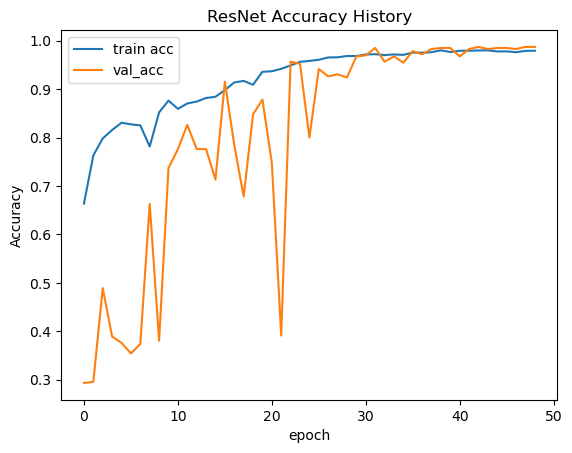

In [68]:
plt.plot(reshist.acc, label='train acc', c='C0')
plt.plot(reshist.val_acc, label='val_acc', c='C1')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('ResNet Accuracy History')
plt.show()
# 35 epoch 이후부터 수렴 확인

* ResNet Spec
* 파라미터 : 102,243개 (top 포함)
* 검증세트 정확도 0.987
* 32개 이미지 처리속도 ~350ms  
-> 개당 이미지 처리속도 = 10.93ms ~ 91FPS (CPU기준)

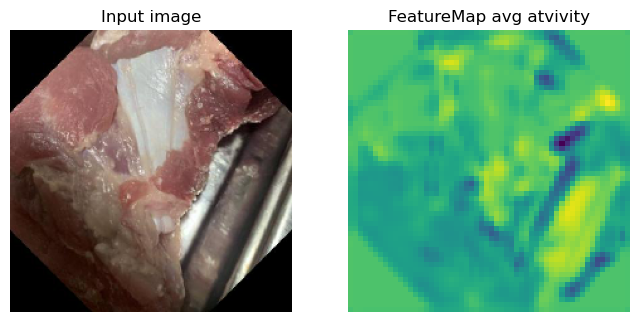

In [84]:
# avg Pool 이전 마지막 Conv layer확인
resnet.layers[-5]._name = 'act_check_layer'
def ShowActivity(model):
    example = X_train[np.random.choice(100, size=1).tolist()]
    example = tf.convert_to_tensor(example, dtype='float32')
    temp = keras.models.Model(inputs=model.inputs,
                              outputs=model.get_layer('act_check_layer').output)
    activity = temp.predict(example, verbose=0).squeeze()
    
    fig, ax = plt.subplots(1,2, figsize=(8,8))
    ax[0].imshow(example.numpy().squeeze())
    ax[0].axis('off')
    ax[0].set_title('Input image')
    
    ax[1].imshow(activity.mean(axis=-1))
    ax[1].axis('off')
    ax[1].set_title('FeatureMap avg atvivity')

    plt.show()

ShowActivity(resnet)

### Custom ResNetV2
* MBConv Block및 SEBlock을 사용하여 파라미터수를 크게 높이지않고 성능을 올려보고자 한다.
* MBConv에서 정확도를 높이고자 DWConv후에 SEBlock을 적용하고 Projection
* Activation : ReLU6. (h-swish는 깊은 layer에서 주로 효과가 있기에 채택x)
* 파라미터 개수 : 109,798개

In [59]:
def SEBlock_Build(inputs, r):
    """
    inputs : DWConv2D (activated)
    Squeeze & Excitation Block
    Excitation은 FC(=Dense)사용
    r : FC layer의 축소비율
    """
    input_channel = inputs.shape[-1]
    
    # Squeeze 1x1xC
    layer = keras.layers.GlobalAveragePooling2D()(inputs)
    layer = keras.layers.Reshape([1,1,input_channel])(layer)
    
    # Excitation : 1x1xC/r 로 축소후 다시 1x1xC로 팽창 (사실상의 AE구조)
    layer = keras.layers.Dense(int(input_channel/r), activation='relu',
                               kernel_initializer='he_uniform')(layer)
    layer = keras.layers.Dense(input_channel, activation='sigmoid')(layer)
    outputs = keras.layers.Multiply()([inputs, layer])
    return outputs
    
def MBConvk3_Build(inputs, width_r, output_channel=None, start=False, down=False):
    """
    Inverted Bottleneck : input channel을 width_r배 팽창
    Pre-activation 구조
    Depthwise Conv 사용
    Activation : ReLU6
    커널은 3x3
    stem에서 처음 적용시 팽창 생략
    down-sampling시 short-cut도 사이즈 조정
    Output channel을 특정하지않으면 자동으로 input channel로 설정
    """
    input_channel = inputs.shape[-1]
    channels = int(input_channel * width_r)
    if output_channel==None:
        output_channel = input_channel
        
    # from n-1 projection layer
    # projection layer의 activation은 그냥 ReLU
    layer = keras.layers.BatchNormalization()(inputs)
    layer = keras.layers.ReLU()(layer) 
    
    ### 1x1 팽창
    if start==False: # Stem이 input이면 생략
        layer = keras.layers.Conv2D(
            channels, 1,
            kernel_initializer='he_uniform',
            use_bias=False)(layer)
        layer = keras.layers.BatchNormalization()(layer)
        layer = keras.layers.ReLU(max_value=6.0)(layer)
    
    ### DWConv
    if down:
        stride = 2
    else:
        stride = 1
    layer = keras.layers.DepthwiseConv2D(
        3, padding='same',
        use_bias=False,
        strides=stride,
        depthwise_initializer='he_uniform',)(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.ReLU(max_value=6.0)(layer)
    
    ### Squeeze & Excitation 축소비 10
    layer = SEBlock_Build(layer, 10)
    
    ### projection
    layer = keras.layers.Conv2D(
        output_channel, 1, padding='same',
        use_bias=False,
        kernel_initializer='he_uniform')(layer)
    
    ### Residual Connection
    # down-sampling이거나 채널 달라지면 short-cut경로도 1x1conv로 채널조정
    if down or (output_channel!=input_channel):
        inputs = keras.layers.Conv2D(
            output_channel, 1, padding='same',
            use_bias=False,
            strides=stride)(inputs)
        
    outputs = keras.layers.Add()([inputs, layer])
    
    return outputs
    
def CustomResNetV2():
    inputs = keras.layers.Input(shape=[224,224,3])
    # 데이터 증강 레이어 추가
    aug = keras.layers.RandomFlip()(inputs)
    aug = keras.layers.RandomBrightness(factor=0.1,
                                        value_range=[0.0, 1.0])(aug)
    aug = keras.layers.RandomContrast(factor=0.1)(aug)
    
    # Net시작 : 7x7 32채널, stride=2(down-sample by2)
    layer = keras.layers.Conv2D(32, 3, strides=2, padding='same',
                                kernel_initializer='he_uniform',
                                use_bias=False)(aug)
    
    # MBConv build
    # 112x112 2block
    layer = MBConvk3_Build(layer, 3, output_channel=16, start=True)
    layer = MBConvk3_Build(layer, 3)
    
    # 56x56 2block
    layer = MBConvk3_Build(layer, 3, output_channel=32, down=True)
    layer = MBConvk3_Build(layer, 3)
    
    # 28x28 3block
    layer = MBConvk3_Build(layer, 3, output_channel=64, down=True)
    layer = MBConvk3_Build(layer, 3)
    layer = MBConvk3_Build(layer, 3)
    
    # Top은 Custom ResNet과 같은구조
    layer = keras.layers.GlobalAveragePooling2D()(layer)
    layer = keras.layers.Dense(64, activation='relu')(layer)
    outputs = keras.layers.Dense(3, activation='softmax')(layer)
    
    model = keras.models.Model(inputs=inputs, outputs=outputs,
                               name='Custom_ResNetV2')
    model.compile(optimizer=keras.optimizers.Adam(0.01),
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
    return model

resnetv2 = CustomResNetV2()
# resnetv2.summary()
resnetv2.save(path+'Custom_ResNetV2.keras')
# 파라미터 개수 : 109,798개

In [70]:
# ResNetV2 불러와서 평가
resnetv2 = keras.models.load_model('Section3_project/from_colab_data/Trained_ResNetV2.keras')
_, resnetv2_acc = resnetv2.evaluate(valid_ds.batch(32))
print(f"ResNetV2 validation accuracy : {round(resnetv2_acc,3)}")
resv2hist = pd.read_csv('Section3_project/from_colab_data/ResNetV2Hist.csv')
# 정확도 0.996

15/15 [==============================] - 6s 321ms/step - loss: 0.0333 - acc: 0.9957
ResNetV2 validation accuracy : 0.996


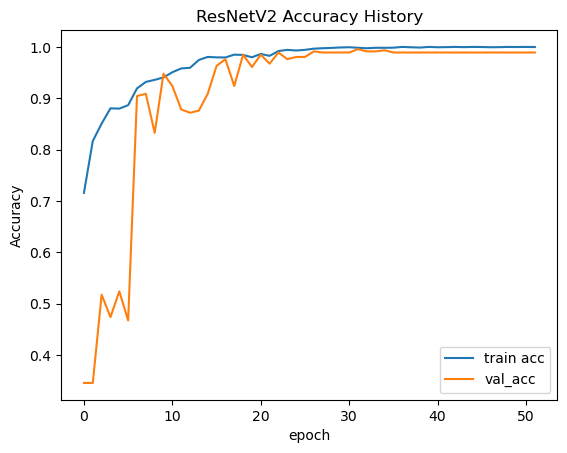

In [71]:
plt.plot(resv2hist.acc, label='train acc', c='C0')
plt.plot(resv2hist.val_acc, label='val_acc', c='C1')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('ResNetV2 Accuracy History')
plt.show()
# 25 epoch 이후부터 수렴 확인

* Custom ResNetV2 Spec
* 파라미터 : 109,798개 (top 포함)
* 검증세트 정확도 0.996 (기존보다 약 +1% 상승)
* 32개 이미지 처리속도 ~320ms  
-> 개당 이미지 처리속도 = 10ms ~ 100FPS (CPU기준)

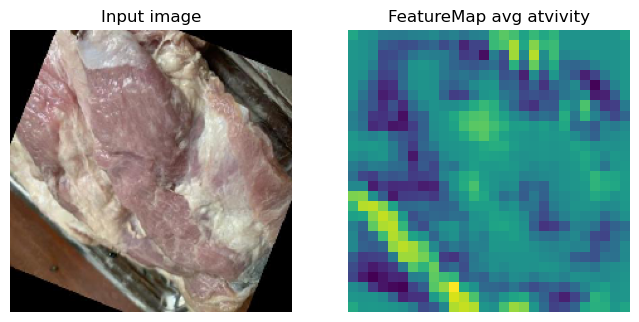

In [179]:
resnetv2.layers[-5]._name = 'act_check_layer'
ShowActivity(resnetv2)

### 스펙비교 및 모델채택

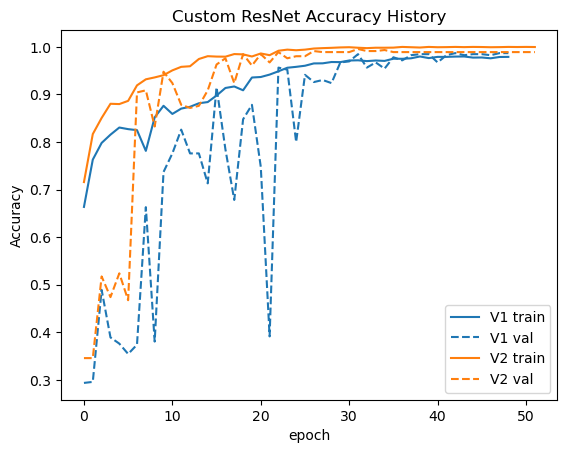

In [125]:
plt.plot(reshist.acc, label='V1 train', c='C0')
plt.plot(reshist.val_acc, '--', label='V1 val', c='C0')
plt.plot(resv2hist.acc, label='V2 train', c='C1')
plt.plot(resv2hist.val_acc, '--', label='V2 val', c='C1')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Custom ResNet Accuracy History')
plt.show()

* 둘 모두 BaseModel보단 높은 정확도를 가진다.
* ResNetV2가 V1보다 빠르게 학습하고, 더 높은 정확도를 가진다.
    * V1정확도 98.5%, V2정확도 99.6%
* 추론속도는 V2가 V1보다 10%정도 빠르다.
* 파라미터 개수는 둘 모두 10만개 정도로 비슷하다.  
=> **ResNetV2를 채택**

### 모델 평가
* ResNetV2를 Test set으로 최종평가

In [141]:
from sklearn.metrics import accuracy_score, classification_report

# Test set으로 정확도 평가
test_pred = resnetv2.predict(X_test, verbose=0).argmax(axis=1)

print(f'Test acc : {round(test_acc,4)}\n')
print(classification_report(y_test, test_pred))

# Test acc : 0.982
# Test F1 :  신선:0.97, 주의:0.98, 상함:1
# Latency : 10ms (CPU)

Test acc : 0.9823

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        74
           1       0.97      0.99      0.98        86
           2       1.00      1.00      1.00        66

    accuracy                           0.98       226
   macro avg       0.98      0.98      0.98       226
weighted avg       0.98      0.98      0.98       226



**Test spec**
* 224x224x3 Input
* 테스트 정확도:  0.982
* F1-score:  신선:0.97, 주의:0.98, 상함:1
* Latency:  10ms => 추론속도 100fps
* 모델 용량 : keras format으로 1.71MB

## 한계점 및 추후 해결방향

* **Task가 너무 간단함. 모델에 적용된 다양한 block들의 효과 체감힘듦.**  
=> 고기종류분류, 상한부분 segmentation등의 기능을 추가하는것 고려

* **한종류의 데이터셋만 사용하여 데이터 다양성 부족**  
=> 다양한 종류의 데이터를 수집하여 일반화 성능 확보

* **시간상의 문제로 튜닝없이 대략적으로 모델구성 (정확도는 충분하다.)**  
=> 하이퍼파라미터 튜닝으로 모델을 더 가볍게 구성  
=> MnasNet, EfficientNet의 CompoundSacling개념을 도입하여 아키텍쳐 최적화 고려

* **사용자에게 Model의 기능을 설명하는 부분 부재(xAI)**  
=> 추후 관련지식을 공부하여 기능추가 고려

* **서비스시 사용자 데이터처리 및 훈련 미고려**  
Ex. 고해상도의 휴대폰 사진,동영상을 224x224로 다운샘플링 어떻게 할지  
=> 앱과 연동하는 부분이라 아직 잘 모르겠음..

## 추가 : requirements.txt
* 같은 python 실행환경을 위해 requirements.txt 제작
* 핵심 패키지
    1. python 3.11
    2. tensorflow 2.12
    3. pandas
    4. numpy
    5. matplotlib
    6. sklearn

In [146]:
# 주석 해제하여 저장
# !conda activate sfds
# !conda list -e > requirements.txt